In [ ]:
#Team C ADM 
#Basic step to load changes in the library and for viewing the images.

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Installation of fastAi Library from Pytorch 
#conda install -c pytorch -c fastai fastai

In [10]:
#Loading the fastAi Library
from fastai import *
from fastai.vision import *

In [9]:
#Loading the data
path = "../input/chest_xray/chest_xray/"
print(path)

../input/chest_xray/chest_xray/


In [11]:
# set the batch size i.e. the number of images to train at a time
#Usually, image databases are huge, so we need to feed these images into a GPU using batches, batch size 64 means that we will feed 64 images at once to update parameters of our deep learning model. 
# reduce this number if you get an out of memory error 
bs = 64

In [33]:
# create a data bunch
#fastai is created in a way to read the folders and subfolders automatically using data bunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=False), 
                                  size=224, num_workers=0, 
                                  bs=bs, valid_pct=0.2).normalize(imagenet_stats)
#normalise the data 

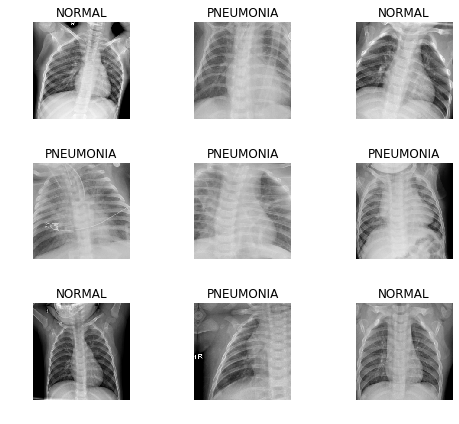

In [14]:
# display 3 rows of data
data.show_batch(rows=3, figsize=(7,6))

In [15]:
# verify the classes
print(data.classes)
len(data.classes),data.c

['NORMAL', 'PNEUMONIA']


(2, 2)

In [36]:
# create a neural network
#To create the transfer learning model we will need to use function create_cnn from Learner class and
#feed a pre-trained model from models class.
learn = create_cnn(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/")

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [37]:
# fit 4 layers
#The ResNet34 model created by create_cnn function have initial layers frozen,
#and we are just going to learn weights of the last fully connected layers.
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.352570,0.216262,0.922289,04:58
1,0.246499,0.192447,0.923997,04:58
2,0.186006,0.172778,0.933390,04:57
3,0.156889,0.164588,0.933390,04:57


In [19]:
# interpret the results
#We will first see which were the categories that the model most confused with one another
#We will try to see if what the model predicted was reasonable or not using ClassificationInterpretation class.
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()



In [40]:
len(data.valid_ds)==len(losses)==len(idxs)

True

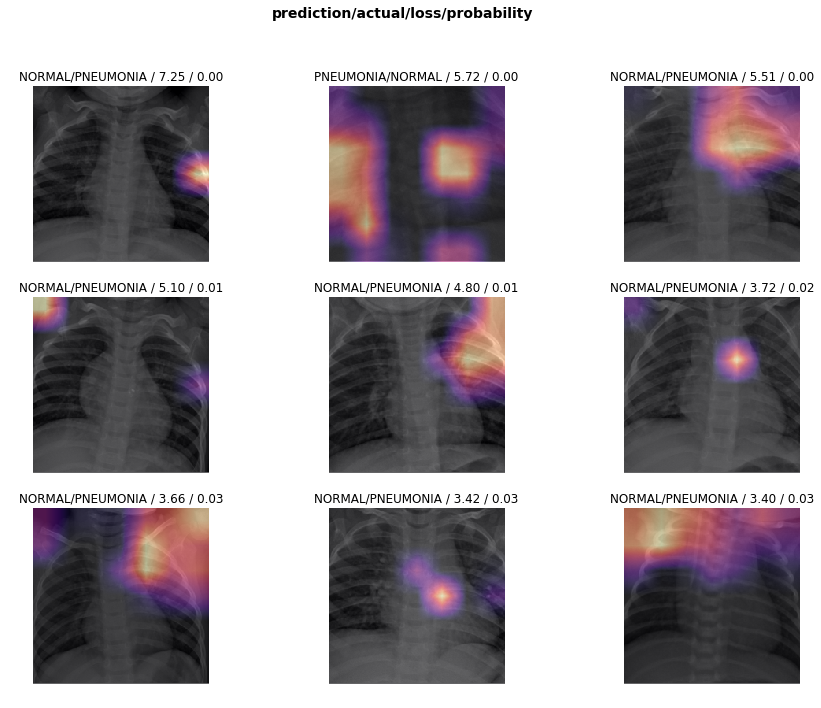

In [38]:
# plot the top losses
interp.plot_top_losses(9, figsize=(15,11))

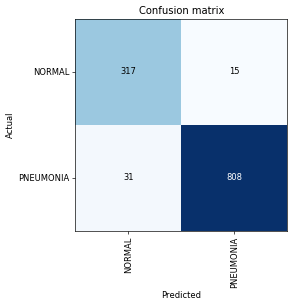

In [42]:
# plot the confusion matrix
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

The number of samples that were pneumonia but predicted as normal is a lot (55) and hence we will train the model more!

In [43]:
learn.save('stage-1')

In [44]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.143121,0.096880,0.961571,05:01


In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


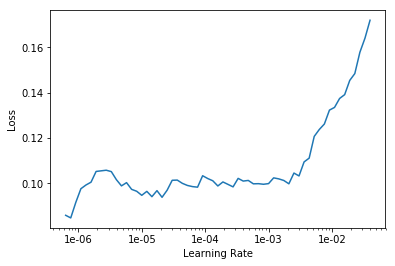

In [47]:
learn.recorder.plot()

In [49]:
# we select the slice with the steepest slope
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.104986,0.326779,0.893254,05:01
1,0.118349,0.460277,0.852263,05:00
2,0.185729,10.086824,0.705380,04:58
3,0.159370,0.142469,0.950470,05:00
4,0.147390,0.247101,0.939368,05:00
5,0.141655,0.109730,0.962425,05:00
6,0.113504,0.087673,0.966695,04:59
7,0.093168,0.113879,0.957301,05:00
8,0.074844,0.075289,0.972673,04:59
9,0.070825,0.084839,0.968403,04:58


In [29]:
# interpret the results
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

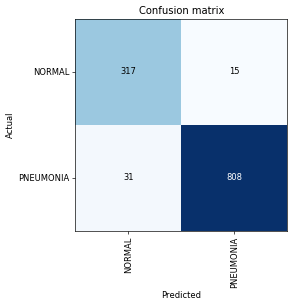

In [30]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

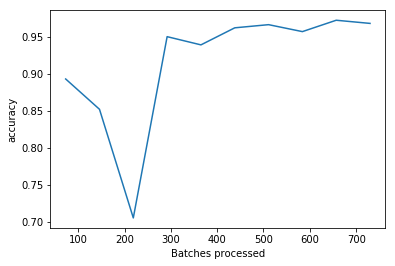

In [51]:
learn.recorder.plot_metrics()

In [1]:
cm=interp.confusion_matrix()
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp + tn)/(tp + tn + fp + fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
F1= 2*(recall * precision) / (recall + precision)
print("F1 score of the model is {:.2f}".format(F1))
print("Accuracy of the model is {:.2f}".format(accuracy))

Recall of the model is 0.96
Precision of the model is 0.98
F1 score of the model is 0.97
Accuracy of the model is 0.96


We have managed to significantly reduce the error rate and predict the Pneumonia cases correctly which is the class we care about!